<a href="https://colab.research.google.com/github/bamboo-nova/Hololive_NPdiscriminator/blob/master/NP_hololive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Driveのマウント 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 必要なモジュールのインストール

In [0]:
# MeCabをcolabで使えるようにする
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3
# Neologd
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a
# emoji
!pip install emoji

# 必要なvtuberのテキストデータを収集する(訓練データ)

In [0]:
# TwitterのCREDENTIALS情報を持っていない方は、解析を行う前に以下のブログなどを参考にして作成してください。
# https://qiita.com/kngsym2018/items/2524d21455aac111cdee#consumer-api-keys%E3%82%A2%E3%82%AF%E3%82%BB%E3%82%B9%E3%83%88%E3%83%BC%E3%82%AF%E3%83%B3%E6%83%85%E5%A0%B1%E3%82%92%E4%BD%BF%E7%94%A8%E3%81%97%E3%81%9Fpython%E3%82%B9%E3%82%AF%E3%83%AA%E3%83%97%E3%83%88

TWITTER_CREDENTIALS = {
  'CONSUMER_KEY': 'xxxxxxxxxxxxxxxxxxxxxxx',
  'CONSUMER_SECRET': 'xxxxxxxxxxxxxxxxxxxxxxx',
  'ACCESS_TOKEN': 'xxxxxxxxxxxxxxxxxxxxxxx',
  'ACCESS_TOKEN_SECRET': 'xxxxxxxxxxxxxxxxxxxxxxx'
}
TWITTER_NAME = 'xxxxxxxxxxxxxxxxxxxxxxx'

In [0]:
import pandas as pd
import numpy as np
import os, sys, json
import tweepy
from datetime import timedelta
import time
import emoji
import pickle

auth = tweepy.OAuthHandler(TWITTER_CREDENTIALS['CONSUMER_KEY'], TWITTER_CREDENTIALS['CONSUMER_SECRET'])
auth.set_access_token(TWITTER_CREDENTIALS['ACCESS_TOKEN'],TWITTER_CREDENTIALS['ACCESS_TOKEN_SECRET'])

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Hololive/Hololive.csv')
hashtags_list = df['Hashtags'].values
df.head(31) # ホロライブメンバーのTwitterのIDや対応しているハッシュタグを表にしてまとめた(一応、サブ垢も含めています)

,Name,ID,Chara,Hashtags,Validation
0,ときのそら,tokino_sora,1,#ときのそら #ときのそら生放送,1
1,さくらみこ,sakuramiko35,0,#さくらみこ #みこなま,0
2,兎田ぺこら,usadapekora,0,#兎田ぺこら #ぺこらいぶ #野うさぎ同盟,0
3,天音かなた,amanekanatach,0,#天音かなた #かなじゅーる #天界学園放送部 #かなたーと #PPカット #天音かなたボイ...,0
4,角巻わため,tsunomakiwatame,1,#角巻わため #わためいと #つのまきあーと #ドドドライブ #わたわた動画,0
5,大空スバル,oozorasubaru,1,#大空スバル #生スバル #プロテインスバル #スバ友 #きりぬきスバル,0
6,湊あくあ,minatoaqua,0,#湊あくあ #あくあーと #湊あくあ生放送,0
7,星街すいせい,suisei_hosimati,1,#星街すいせい #ほしまちぎゃらりー #ほしまちすたじお #星詠み,1
8,癒月ちょこ,yuzukichococh,1,#癒月ちょこ #しょこらーと,0
9,夜空メル,yozoramel,1,#夜空メル #メル生放送 #メルArt #かぷ民,1


In [0]:
# ハッシュタグからデータを取得したい場合はこちらを利用してみてください。
api = tweepy.API(auth)
def collect_data(df):
  for name, id, hashtags, chara, val in zip(df['Name'],df['ID'],df['Hashtags'],df['Chara'],df['Validation']):
    if chara == 1:
      main_dir = '/content/drive/My Drive/Colab Notebooks/Hololive/Datasets/positive'
    elif chara == 0:
      main_dir = '/content/drive/My Drive/Colab Notebooks/Hololive/Datasets/negative'
    hashtag = hashtags.split(' ')
    for h in hashtag:
      print(h)
      tweets = [tweet.text for tweet in api.search(q=h, lang='ja', result_type='recent',count=1000) if (list(tweet.text)[:2]!=['R', 'T']) & (list(tweet.text)[0]!='@')]
      with open(main_dir+'/'+h+'.csv', 'wb') as f:
        pickle.dump(tweets, f)
      time.sleep(10)

In [0]:
# 各メンバーのツイッターIDからテキストデータを取得する関数
api = tweepy.API(auth)
#df = df.iloc[3:]
def collect_data(df,index):
  df = df[df.Validation==index] #index=0は訓練データ、index=1は検証用の独立データを収集する
  for name, id, hashtags, chara, val in zip(df['Name'],df['ID'],df['Hashtags'],df['Chara'],df['Validation']):
    print(name)
    if chara == 1 and index == 0:
      main_dir = '/content/drive/My Drive/Colab Notebooks/Hololive/Datasets/positive'
    elif chara == 0 and index == 0:
      main_dir = '/content/drive/My Drive/Colab Notebooks/Hololive/Datasets/negative'
    elif index == 1:
      main_dir = '/content/drive/My Drive/Colab Notebooks/Hololive/Datasets/valid'
    texts = []
    pages = np.arange(40)
    for page in pages:
      results = api.user_timeline(screen_name=id, count=200, page=page+1)
      for r in results:
        if (list(r.text)[:2]!=['R', 'T']) & (list(r.text)[0]!='@'):
          texts.append(r.text)
    
    with open(main_dir+'/'+name+'.csv', 'w', encoding='utf-8') as f:
      for text in texts:
        data = ''.join(text.strip('\n'))
        f.write(data+'\n')

In [0]:
# TweepyのAPIの都合上、取得するツイートデータが大量過ぎるとエラーが出るので、エラーが発生した場合はilocの値を変えて15分後に再実行してください。
collect_data(df.iloc[0:],0) # 訓練データ
#collect_data(df.iloc[0:],1) # 検証データ

# データ分析(訓練と予測)

GPUで学習を行うようになっているので、実行する前に「編集」→「ノートブックの設定」からGPUに切り替えてください。

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import re
import codecs
import csv

from sklearn.model_selection import train_test_split
import random
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.optim as optim

import codecs
import re
import emoji
import MeCab
import subprocess
import glob
import time

cmd='echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
path = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                           shell=True).communicate()[0]).decode('utf-8')
tagger=MeCab.Tagger("-Owakati -d {0}".format(path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Hololive/Hololive.csv')
hashtags_list = df['Hashtags'].values
filters = '|'.join(['|'.join(h.split()) for h in hashtags_list])
filters = filters.replace('#','')

In [0]:
code_regex1 = re.compile(r'[!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥％]')
code_regex2 = re.compile(r'[、。，．・：；？！゛゜｀´¨＾丶＿￣ヽヾゝゞ〃仝々〆〇ー―‐／＼～∥｜…‥‘’“”（）〔〕［］｛｝〈〉《》「」『』【】＋－±×÷＝≠＜＞≦≧∞∴♂♀°′″℃￥＄￠￡％＃＆＊＠§☆★○●◎◇◆□■△▲▽▼※〒→←↑↓〓∈∋⊆⊇⊂⊃∪∩∧∨￢⇒⇔∀∃∠⊥⌒∂∇≡≒≪≫√∽∝∵∫∬Å‰♯♭♪†‡¶ΓΔΘΛΞΠΣΦΧΨΩαβγδεζηθικλμνξοπρστυφχψωБГДЁЖЗИЙКЛПФЦЧШЩЪЫЭЮЯбвгдеёжзийклмнптфцчшщъыьэюя─│┌┐┘└├┬┤┴┼━┃┏┓┛┗┣┳┫┻╋┠┯┨┷┿┝┰┥┸╂丶乙一丿亅人丁二入八卜又厂匸匚勹凵几冫冖冂儿亠厶乂了丁卩巾三山士己凡彳彡川廾广巛介屮尸宀口囗兀于个干爻殳戈弖夭夬卞卅从廿凸凹卍回豸囲因回固困四囚!#$%&()=|+*{}<>[]?_\/.,:;"`~^@\-1234567890ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz１２３４５６７８９０ＡＢＣＤＥＦＧＨＩＪＫＬＭＮＯＰＱＲＳＴＵＶＷＸＹＺａｂｃｄｅｆｇｈｉｊｋｌｍｎｏｐｑｒｓｔｕｖｗｘｙｚ]')
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
                           "]+", flags=re.UNICODE)

def remove_emoji(src_str):
    return ''.join(c for c in src_str if c not in emoji.UNICODE_EMOJI)
emojis = '🤗⭕🤓🤔🤘🦁⭐🆗🆖🈲🤐🤗🤖🤑🆙⏩☺️⬇️'

def preprocess(lines):
  result = []
  for line in lines:
    line = re.sub('[　]'," ",line)
    line = re.sub('[ ]',"",line)
    line = re.sub(r'(http|https)://.+',"",line)
    line = re.sub(filters,'',line)
    #line = re.sub('ぺこ$|ペコ$',"",line) # 例の人の個性を殺す前処理
    line = re.sub(r'[/[#＃].*/]','',line)
    line = re.sub('RT', "", line)
    line = re.sub('@.+:\s', "", line)
    line = re.sub('[\n\r]',"",line)
    line = re.sub('[\s]'," ",line)
    line = re.sub('[0-9_]',"",line) # 悩んだけど入れる
    line = re.sub('月日',"",line)
    line = re.sub('[円¥]',"",line)
    line = re.sub('[#]',"",line)
    line = re.sub('[*]',"",line)
    #line = line.lower() # 小文字に変換
    line = code_regex1.sub('', line)
    line = code_regex2.sub('', line)
    line = emoji_pattern.sub(r'', line)
    line = re.sub(r'^[qr]+$','',line)
    line = remove_emoji(line)
    line = re.sub('๑╹ᆺ╹', "", line)
    line = re.sub('₍₍◝•̀ㅂ•́◟⁾⁾', "", line)
    line = re.sub('⍨⃝︎|∩˘ω˘∩', "", line)
    line = re.sub('✩°｡⋆⸜॑꒳॑⸝', "", line)
    line = re.sub('୧๑•̀ㅁ•́๑૭', "", line)
    line = re.sub('✧|｡•ᴗ•｡|ω§ﾉ|•̀ᴗ•́و̑̑', "", line)
    line = re.sub(r'♡|✩|´꒳ﾟ・|╮͟͟͞]|╮͟͟͞', "", line)
    if len(line)>3:
      result.append(line) # 3文字以上の文章なら使用する
  return result

In [0]:
positives = glob.glob('/content/drive/My Drive/Colab Notebooks/Hololive/Datasets/positive/*.csv')
negatives = glob.glob('/content/drive/My Drive/Colab Notebooks/Hololive/Datasets/negative/*.csv')
p_train = pd.DataFrame()
n_train = pd.DataFrame()

for p in positives:
  f = open(p, 'r')
  lines = f.readlines()
  res = preprocess(lines)
  df = pd.DataFrame(res)
  p_train = pd.concat([p_train, df])

for n in negatives:
  f = open(n, 'r')
  lines = f.readlines()
  res = preprocess(lines)
  df = pd.DataFrame(res)
  n_train = pd.concat([n_train, df])

p_train.columns = ['text']
n_train.columns = ['text']
p_train['label'] = 1
n_train['label'] = 0

df = pd.concat([p_train,n_train])
df = df.reset_index(drop=True)

In [0]:
class Wakati_index():
  def __init__(self, texts):
    self.word2index = {} # 単語ID辞書を作成する
    self.word2index.update({"<pad>":0})
    self.texts = texts
  
  # 分かち書き
  def make_wakati(self, sentence):
      sentence = tagger.parse(sentence)
      sentence = re.sub(r'(\n|\r)', "", sentence)
      sentence = re.sub(r'[0-9０-９a-zA-Zａ-ｚＡ-Ｚ]+', " ", sentence)
      sentence = re.sub(r'[\．_－―─！＠＃＄％＾＆\-‐|\\＊\“（）＿■×+α※÷⇒—●★☆〇◎◆▼◇△□(：〜～＋=)／*&^%$#@!~`){}［］…\[\]\"\'\”\’:;<>?＜＞〔〕〈〉？、。・,\./『』【】「」→←○《》≪≫\n\u3000]+', "", sentence)
      # スペースで区切って形態素の配列へ
      wakati = sentence.split(" ")
      # 空の要素は削除
      wakati = list(filter(("").__ne__, wakati))
      return wakati

  def indexed_words(self):
    for text in self.texts :
        wakati = self.make_wakati(text)
        for word in wakati:
            if word in self.word2index: continue
            self.word2index[word] = len(self.word2index)
    print("vocab size : ", len(self.word2index)) # 語彙の総数
    return self.word2index, len(self.word2index)

indexed = Wakati_index(df["text"])
word2index, length = indexed.indexed_words()

vocab size :  17462


In [0]:
# データを訓練データとテストデータに分割する
genres = df.label.astype(str)
genres = genres.drop_duplicates()
genre2index = {}
for genre in genres:
    if genre in genre2index: continue
    genre2index[genre] = len(genre2index)
# ラベルの合計を出力
print(len(genre2index))

# 文章を単語IDの系列データに変換
def sentence2index(sentence):
    wakati = indexed.make_wakati(sentence)
    return [word2index[w] for w in wakati]

def genres2index(genre):
    return [genre2index[genre]]

index_datasets_title_tmp = []
index_datasets_genre = []
index_datasets_names = []

# 分かち書きされた文章の長さの最大値を取得。この長さに他の系列の長さを合わせる
max_len = 0
for name, genre in zip(df['text'], df['label']):
    index_title = sentence2index(name)
    index_genre = genre
    index_datasets_title_tmp.append(index_title)
    index_datasets_genre.append(index_genre)
    index_datasets_names.append(name)
    if max_len < len(index_title):
        max_len = len(index_title)
    
# 最大値に満たない短い系列にパディングを追加する(前パディング)
index_datasets_title = []
for title in index_datasets_title_tmp:
    for i in range(max_len - len(title)):
        title.insert(0,0)
    index_datasets_title.append(title)

train_z, test_z, train_x, test_x, train_y, test_y = train_test_split(index_datasets_names, index_datasets_title, index_datasets_genre,
                                                   train_size=0.8)

# バッチでまとめる
def batch(title, genre, name, batch_size=256):
    title_batch = []
    genre_batch = []
    name_batch = []
    title_shuffle, genre_shuffle, name_shuffle = shuffle(title, genre, name)
    for i in range(0, len(title), batch_size):
        title_batch.append(title_shuffle[i:i+batch_size])
        genre_batch.append(genre_shuffle[i:i+batch_size])
        name_batch.append(name_shuffle[i:i+batch_size])
        
    return title_batch, genre_batch, name_batch

2


In [0]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        _, lstm_out = self.lstm(embeds)
        tag_space = self.hidden2tag(lstm_out[0])
        tag_scores = F.log_softmax(tag_space.squeeze())
        return tag_scores

EMBEDDING_DIM = 100 # チューニング
HIDDEN_DIM = 128
VOCAB_SIZE = length
LABEL = 2
print(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE , LABEL)

model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, LABEL)
model = nn.DataParallel(model).to(device)
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99), eps=1e-08, weight_decay=0.01, amsgrad=True)

100 128 17462 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0 	 loss 0.002075772484708334
epoch 1 	 loss 0.0020290319232880542
epoch 2 	 loss 0.0020150222826499373
epoch 3 	 loss 0.0019996183510867624
epoch 4 	 loss 0.0019875293683929342
epoch 5 	 loss 0.001975244681369033
epoch 6 	 loss 0.0019691606856567976
epoch 7 	 loss 0.0019646233363671294
epoch 8 	 loss 0.001962504401873098
epoch 9 	 loss 0.0019618327229255494
epoch 10 	 loss 0.001961024533045607
epoch 11 	 loss 0.001954774803213078
epoch 12 	 loss 0.0019543125399126672
epoch 13 	 loss 0.0019528595684936134
epoch 14 	 loss 0.0019455494911604515
epoch 15 	 loss 0.0019407573966279104
epoch 16 	 loss 0.0019334242632730511
epoch 17 	 loss 0.001926888618132108
epoch 18 	 loss 0.0019177128405612632
epoch 19 	 loss 0.001903192963955772
epoch 20 	 loss 0.0018948873513563948
epoch 21 	 loss 0.0018852274805034764
epoch 22 	 loss 0.0018731624918443867
epoch 23 	 loss 0.001858518270751513
epoch 24 	 loss 0.0018407478616665092
epoch 25 	 loss 0.0018251060875782185
epoch 26 	 loss 0.001807884101

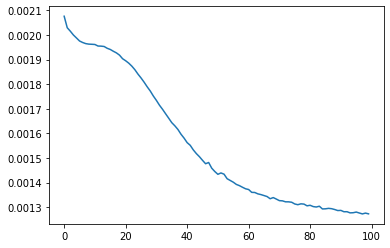

In [0]:
## 学習...1epoch毎に全バッチを学習させてみる。バッチごとに逆伝播して、パラメータを更新させる 
import time

t1 = time.time() 
losses = []
all_losses = []
for epoch in range(100):
    all_loss = 0
    title_batch, genre_batch, name_batch = batch(train_x, train_y, train_z)
    for i in range(len(title_batch)):
        batch_loss = 0
        model.zero_grad()
        
        # 順伝播させるtensorはGPUで処理させるため、device=にGPUをセットする
        inputs = torch.tensor(title_batch[i], device=device)
        # label.size() = (batch_size x 1)なので、squeeze()
        label = torch.tensor(genre_batch[i], device=device).squeeze()
        
        # 新たにパディングに関するIDを追加したので、その影響を緩和するためにこの要素を加える。　
        if inputs.size()[0] > 1:
            out = model(inputs)
            batch_loss = loss_function(out, label)
            batch_loss.backward()
            optimizer.step()

            all_loss += batch_loss.item()
    losses.append(all_loss/len(df))
    print("epoch", epoch, "\t", "loss", all_loss/len(df))
    if all_loss < 0.1: break
print("done.")

# 処理後の時刻
t2 = time.time()
 
# 経過時間を表示
elapsed_time = t2-t1
print(f"経過時間：{elapsed_time}")

# 学習したモデルを保存
torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/Hololive/Datasets/Trained_model.pt")
print("model saved.")

plt.plot(losses)

In [0]:
# Predict using test data.
test_num = len(test_x)
result1 = []
result2 = []
result3 = []
result4 = []
# 正解の件数
a = 0
# 勾配自動計算OFF
with torch.no_grad():
    title_batch, genre_batch, name_batch = batch(test_x, test_y, test_z)
    
    for i in range(len(title_batch)):
        inputs = torch.tensor(title_batch[i], device=device)
        label = torch.tensor(genre_batch[i], device=device)
        name = name_batch[i]
        
        if inputs.size()[0] > 1:
            out = model(inputs)
            _, predict1 = torch.max(out, 1)
            predict = torch.argsort(out,descending=True)
            for j, ans in enumerate(label):
                if predict1[j].item() == ans.item():
                    a+=1
                result1.append(name[j])
                result2.append(ans.item())
                gg1 = predict[j][0].cpu().numpy()
                gg2 = predict[j][1].cpu().numpy()
                result3.append(gg1)
                result4.append(gg2)
print("predict : ", a / test_num) # 予測精度

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


predict :  0.7622739018087855


In [0]:
res1 = pd.DataFrame(result1) # 文章データ
res2 = pd.DataFrame(result2) # 実際のキャラ
res3 = pd.DataFrame(result3) # 予測された中で最も可能性が高いもの
res4 = pd.DataFrame(result4) # 予測された中で二番目に可能性が高いもの

res = pd.concat([res1,res2,res3,res4],axis=1)

# 全体の結果を出力
res.columns=['name','genre','ans1','ans2']
result = res[res.ans1!=0]

In [0]:
def syogo(x):
    for key, value in genre2index.items():
        if x==value:
            return key

result['genre']=result['genre'].apply(lambda x: syogo(x))
result['ans1']=result['ans1'].apply(lambda x: syogo(x))
result['ans2']=result['ans2'].apply(lambda x: syogo(x))
result

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

,name,genre,ans1,ans2
0,おつグラデーション..._(ˇωˇ」∠)_,0,0,1
1,お醤油のボトルすごい顔してる,0,0,1
2,ドヤメガネおいとくっ！,0,0,1
3,・わためは悪くないよねぇtシャツ,0,0,1
4,ものすごーく推しが描きたいのに,0,0,1
...,...,...,...,...
9485,またたくさんお話しよーね(´꒳`)ﾟ.・,0,0,1
9486,録画残さないasmr！,0,0,1
9487,今日もウキウキしていってらっしゃい₍₍◝(•̀ㅂ•́)◟⁾⁾,0,0,1
9488,最近早起きが得意になった気がする！,0,0,1


In [0]:
# 既にモデルを学習済みであれば、ここから
model.eval()
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/Hololive/Datasets/Trained_model.pt'))

<All keys matched successfully>

In [0]:
# ここで簡単に好きな文章を入れて検証できます。
sentence = '''学力テスト'''
title = sentence2index(sentence)
title = torch.tensor(title, device=device)
out = model(title.view(-1,len(title)))

predict = torch.argsort(out,descending=True)

if predict[0]==1:
  print('お前は陰キャ！！')
else:
  print('あなたは陽キャ！！')

あなたは陽キャ！！


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


#テスト検証

In [0]:
validations = glob.glob('/content/drive/My Drive/Colab Notebooks/Hololive/Datasets/valid/*.csv')
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Hololive/Hololive.csv')
members = df[['Name','Chara']]


for v in validations:
  valid_df = pd.DataFrame()
  counter = {'positive': 0, 'negative': 0}
  f = open(v, 'r')
  lines = f.readlines()
  res = preprocess(lines)
  df = pd.DataFrame(res)
  valid_df = pd.concat([valid_df, df])
  valid_df.columns = ['text']
  query = v.strip('/content/drive/My Drive/Colab Notebooks/Hololive/Datasets/valid/{*}.csv')
  chara = members[members.Name == query]
  valid_df['label'] = chara['Chara']
  for name, genre in zip(valid_df['text'], valid_df['label']):
    try:
      title = sentence2index(name)
      title = torch.tensor(title, device=device)
      out = model(title.view(-1,len(title)))
      predict = torch.argsort(out,descending=True)
      if predict[0] == 1:
        counter['positive'] += 1
      elif predict[0] == 0:
        counter['negative'] += 1
    except:
      pass
  result = counter['positive']/(sum(counter.values()))
  if counter['positive']>counter['negative']:
    print('%sは陽キャです' % query)
    print(result,sum(counter.values()),counter['positive'],len(valid_df))
    print('----------------------------')
  elif counter['positive']<counter['negative']:
    print('%sは陰キャです' % query)
    print(result,sum(counter.values()),counter['positive'],len(valid_df))
    print('----------------------------')
  else:
    print('%sは中性です' % query)
    print('----------------------------')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


ときのそらは陽キャです
0.7045305318450427 3046 2146 4870
----------------------------
星街すいせいは陰キャです
0.4129251700680272 2940 1214 4634
----------------------------
夜空メルは陽キャです
0.5901213171577123 1154 681 1844
----------------------------
白上フブキは陽キャです
0.5638173302107728 1708 963 3570
----------------------------
夏色まつりは陽キャです
0.5016304347826087 1840 923 2562
----------------------------
夏色まつり2は陽キャです
0.5537885874649204 2138 1184 3748
----------------------------
姫森ルーナは陰キャです
0.36826524570751923 1689 622 2306
----------------------------
白銀ノエルは陰キャです
0.42934293429342935 3333 1431 4976
----------------------------
アキロゼは陰キャです
0.470281124497992 2490 1171 4158
----------------------------
AZKは陽キャです
0.862909090909091 2750 2373 2821
----------------------------
不知火フレアは陽キャです
0.5693251533742332 1630 928 2525
----------------------------
ロボ子さんは陽キャです
0.5026868588177821 2047 1029 3153
----------------------------
猫又おかゆは陰キャです
0.41079199303742386 2298 944 3219
----------------------------
桐生ココは陽キャです
0.516461916461916